In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# Load a Clean Dataset

In [2]:
clean_data = pd.read_csv('/content/sample_data/Tweets.csv')

In [4]:
clean_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

<Axes: xlabel='airline_sentiment', ylabel='count'>

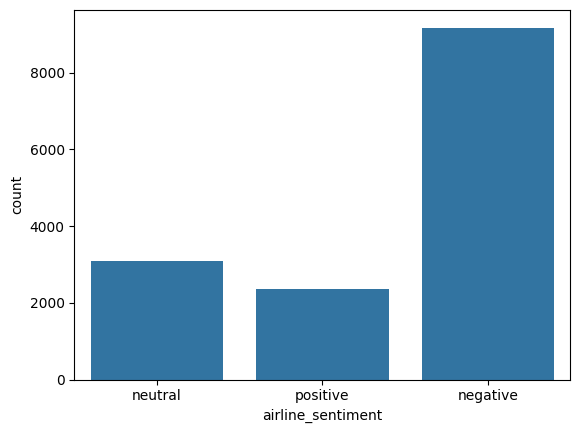

In [6]:
sns.countplot(x = "airline_sentiment", data = clean_data)

# Basic Text Pre-Processing

In [7]:
waste_col = ['tweet_id', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone']

data = clean_data.drop(waste_col, axis = 1)

In [8]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [9]:
def sentiment(x):
    if x == 'positive':
        return 1
    elif x == 'negative':
        return -1
    else:
        return 0

In [10]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'\w+')

In [12]:
# As this dataset is fetched from twitter so it has lots of people tag in tweets
# we will remove them
tags = r"@\w*"

In [13]:
def preprocess_text(sentence, stem = False):

    sentence = [re.sub(tags, "", sentence)]
    text = []
    for word in sentence:

        if word not in stopwords:

            if stem:
                text.append(stemmer.stem(word).lower())
            else:
                text.append(word.lower())
    return tokenizer.tokenize(" ".join(text))

In [14]:
print(f"Orignal Text : {data.text[11]}")
print()
print(f"Preprocessed Text : {preprocess_text(data.text[11])}")

Orignal Text : @VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D

Preprocessed Text : ['i', 'lt', '3', 'pretty', 'graphics', 'so', 'much', 'better', 'than', 'minimal', 'iconography', 'd']


In [15]:
data.text = data.text.map(preprocess_text)
data.head()



,airline_sentiment,text
0,neutral,"[what, said]"
1,positive,"[plus, you, ve, added, commercials, to, the, e..."
2,neutral,"[i, didn, t, today, must, mean, i, need, to, t..."
3,negative,"[it, s, really, aggressive, to, blast, obnoxio..."
4,negative,"[and, it, s, a, really, big, bad, thing, about..."


# One-Hot Encoding

In [16]:
#this is an example vocabulary just to make concept clear
sample_vocab = ['the', 'cat', 'sat', 'on', 'mat', 'dog', 'run', 'green', 'tree']

In [17]:
# vocabulary of words present in dataset
data_vocab = []
for text in data.text:
    for word in text:
        if word not in data_vocab:
            data_vocab.append(word)


In [18]:
#function to return one-hot representation of passed text
def get_onehot_representation(text, vocab = data_vocab):
    onehot_encoded = []
    for word in text:
        temp = [0]*len(vocab)
        temp[vocab.index(word)-1] = 1
        onehot_encoded.append(temp)
    return onehot_encoded

print("One Hot Representation for sentence \"the cat sat on the mat\" :")
get_onehot_representation(['the', 'cat', 'sat', 'on', 'the', 'mat'], sample_vocab)

One Hot Representation for sentence "the cat sat on the mat" :


[[0, 0, 0, 0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0, 0, 0, 0, 0]]

In [19]:
print(f'Length of Vocabulary : {len(data_vocab)}')
print(f'Sample of Vocabulary : {data_vocab[302 : 312]}')


Length of Vocabulary : 14276
Sample of Vocabulary : ['number', 'awaiting', 'return', 'phone', 'call', 'prefer', 'use', 'self', 'service', 'option']


We have 14276 different words in a given dataset thus this implies each word representation for one-hot encoding schema will be of 14276-dimensional vector mark that this much big representation is just for a single word if we consider the representation of a sentence which consist of let say 20 words in it then it will be represented with (20,14276) sized matrix.

In [20]:
sample_one_hot_rep = get_onehot_representation(data.text[7], data_vocab)
print(f"Shapes of a single sentence : {np.array(sample_one_hot_rep).shape}")

Shapes of a single sentence : (15, 14276)


In [21]:
data.head()

,airline_sentiment,text
0,neutral,"[what, said]"
1,positive,"[plus, you, ve, added, commercials, to, the, e..."
2,neutral,"[i, didn, t, today, must, mean, i, need, to, t..."
3,negative,"[it, s, really, aggressive, to, blast, obnoxio..."
4,negative,"[and, it, s, a, really, big, bad, thing, about..."


# Bag of words

Bag of words (BoW) is a classical text representation technique that has been used commonly in NLP, especially in text classification problems. The key idea behind it is as follows: represent the text under consideration as a bag (collection) of words while ignoring the order and context.

Similar to one-hot encoding, BoW maps words to unique integer IDs between 1 and |V|. Each document in the corpus is then converted into a vector of |V| dimensions were in the ith component of the vector, i = wid, is simply the number of times the word w occurs in the document, i.e., we simply score each word in V by their occurrence count in the document.

Consider an example:

let say we have a vocabulary V consisting of words --> {the, cat, sat, in, hat, with} then the bag of word representation of a few sentences will be given as

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
sample_bow = CountVectorizer()


In [24]:
sample_corpus = ["the cat sat", "the cat sat in the hat", "the cat with the hat"]

sample_bow.fit(sample_corpus)

def get_bow_representation(text):
        return sample_bow.transform(text)

print(f"Vocabulary mapping for given sample corpus : \n {sample_bow.vocabulary_}")
print("\nBag of word Representation of sentence 'the cat cat sat in the hat'")
print(get_bow_representation(["the cat cat sat in the hat"]).toarray())

Vocabulary mapping for given sample corpus : 
 {'the': 4, 'cat': 0, 'sat': 3, 'in': 2, 'hat': 1, 'with': 5}

Bag of word Representation of sentence 'the cat cat sat in the hat'
[[2 1 1 1 2 0]]


Sometimes, we don’t care about the frequency of occurrence of words in the text and we only want to represent whether a word exists in the text or not. In such cases, we just initialize CountVectorizer with the binary=True

In [25]:
sample_bow = CountVectorizer(binary = True)

sample_corpus = ["the cat sat", "the cat sat in the hat", "the cat with the hat"]

sample_bow.fit(sample_corpus)

def get_bow_representation(text):
        return sample_bow.transform(text)

print(f"Vacabulary mapping for given sample corpus : \n {sample_bow.vocabulary_}")
print("\nBag of word Representation of sentence 'the the the the cat cat sat in the hat'")
print(get_bow_representation(["the the the the cat cat sat in the hat"]).toarray())

Vacabulary mapping for given sample corpus : 
 {'the': 4, 'cat': 0, 'sat': 3, 'in': 2, 'hat': 1, 'with': 5}

Bag of word Representation of sentence 'the the the the cat cat sat in the hat'
[[1 1 1 1 1 0]]


In [26]:
# generate bag of word representation for given dataset

bow = CountVectorizer()
bow_rep = bow.fit_transform(data.loc[:, 'text'].astype('str'))

In [27]:
print(f"Shape of Bag of word representaion matrix : {bow_rep.toarray().shape}")


Shape of Bag of word representaion matrix : (14640, 14238)


# Bag of N-Grams

The following code cell shows an example of a BoN representation considering 1–3 n-gram word features to represent the corpus that we’ve used so far.

In [28]:
# Bag of 1-gram (unigram)
from sklearn.feature_extraction.text import CountVectorizer

sample_boN = CountVectorizer(ngram_range = (1, 1))

sample_corpus = ["the cat sat", "the cat sat in the hat", "the cat with the hat"]

sample_boN.fit(sample_corpus)

def get_boN_representation(text):
        return sample_boN.transform(text)

print(f"Unigram Vocabulary mapping for given sample corpus : \n {sample_boN.vocabulary_}")
print("\nBag of 1-gram (unigram) Representation of sentence 'the cat cat sat in the hat'")
print(get_boN_representation(["the cat cat sat in the hat"]).toarray())

Unigram Vocabulary mapping for given sample corpus : 
 {'the': 4, 'cat': 0, 'sat': 3, 'in': 2, 'hat': 1, 'with': 5}

Bag of 1-gram (unigram) Representation of sentence 'the cat cat sat in the hat'
[[2 1 1 1 2 0]]


In [29]:
# Bag of 2-gram (bigram)
from sklearn.feature_extraction.text import CountVectorizer

sample_boN = CountVectorizer(ngram_range = (2, 2))

sample_corpus = ["the cat sat", "the cat sat in the hat", "the cat with the hat"]

sample_boN.fit(sample_corpus)

def get_boN_representation(text):
        return sample_boN.transform(text)

print(f"Bigram Vocabulary mapping for given sample corpus : \n {sample_boN.vocabulary_}")
print("\nBag of 2-gram (bigram) Representation of sentence 'the cat cat sat in the hat'")
print(get_boN_representation(["the cat cat sat in the hat"]).toarray())

Bigram Vocabulary mapping for given sample corpus : 
 {'the cat': 4, 'cat sat': 0, 'sat in': 3, 'in the': 2, 'the hat': 5, 'cat with': 1, 'with the': 6}

Bag of 2-gram (bigram) Representation of sentence 'the cat cat sat in the hat'
[[1 0 1 1 1 1 0]]


In [30]:
# Bag of 3-gram (trigram)
from sklearn.feature_extraction.text import CountVectorizer

sample_boN = CountVectorizer(ngram_range = (3, 3))

sample_corpus = ["the cat sat", "the cat sat in the hat", "the cat with the hat"]

sample_boN.fit(sample_corpus)

def get_boN_representation(text):
        return sample_boN.transform(text)

print(f"Trigram Vocabulary mapping for given sample corpus : \n {sample_boN.vocabulary_}")
print("\nBag of 3-gram (trigram) Representation of sentence 'the cat cat sat in the hat'")
print(get_boN_representation(["the cat cat sat in the hat"]).toarray())

Trigram Vocabulary mapping for given sample corpus : 
 {'the cat sat': 4, 'cat sat in': 0, 'sat in the': 3, 'in the hat': 2, 'the cat with': 5, 'cat with the': 1, 'with the hat': 6}

Bag of 3-gram (trigram) Representation of sentence 'the cat cat sat in the hat'
[[1 0 1 1 0 0 0]]


# TF-IDF

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

sample_corpus = ["the cat sat", "the cat sat in the hat", "the cat with the hat"]
tfidf_rep = tfidf.fit_transform(sample_corpus)
print(f"IDF Values for sample corpus : {tfidf.idf_}")


print("TF-IDF Representation for sentence 'the cat sat in the hat' :")
print(tfidf.transform(["the cat sat in the hat"]).toarray())

IDF Values for sample corpus : [1.         1.28768207 1.69314718 1.28768207 1.         1.69314718]
TF-IDF Representation for sentence 'the cat sat in the hat' :
[[0.29903422 0.385061   0.50630894 0.385061   0.59806843 0.        ]]


# Word2vec Word Embeddings

In [34]:
#from gensim.models import Word2Vec, KeyedVectors
#pretrained_path = "../input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin"

#Word2VecModel = KeyedVectors.load_word2vec_format(pretrained_path, binary = True)

In [36]:
#print(Word2VecModel.most_similar('good'))

In [37]:
#print(Word2VecModel['good'])

In [38]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

print("Sentences on Which We are gonna train our CBOW Word2Vec Model:\n")
print(common_texts)

Our_CBOW_Word2Vec_Model = Word2Vec(common_texts, vector_size = 10, window = 5, min_count = 1, workers = 8, sg = 0)
Our_CBOW_Word2Vec_Model.save("Our_CBOW_Word2Vec_Model.w2v")
print("Model Saved")


Sentences on Which We are gonna train our CBOW Word2Vec Model:

[['human', 'interface', 'computer'], ['survey', 'user', 'computer', 'system', 'response', 'time'], ['eps', 'user', 'interface', 'system'], ['system', 'human', 'system', 'eps'], ['user', 'response', 'time'], ['trees'], ['graph', 'trees'], ['graph', 'minors', 'trees'], ['graph', 'minors', 'survey']]
Model Saved


In [39]:
Our_CBOW_Word2Vec_Model.wv.most_similar('human', topn = 5)

[('graph', 0.3586882948875427),
 ('system', 0.22743132710456848),
 ('time', 0.1153423935174942),
 ('interface', 0.09816545248031616),
 ('survey', 0.01448808517307043)]

In [40]:
Our_CBOW_Word2Vec_Model.wv['human']


array([-0.00410223, -0.08368949, -0.05600012,  0.07104538,  0.0335254 ,
        0.0722567 ,  0.06800248,  0.07530741, -0.03789154, -0.00561806],
      dtype=float32)

# Glove Word Embeddings

In [42]:
#Glove_path = "../input/glove6b/glove.6B.100d.txt"
#from gensim.scripts.glove2word2vec import glove2word2vec
#word2vec_output_file = 'glove.6B.100d.txt.word2vec'
#glove2word2vec(Glove_path, word2vec_output_file)

In [44]:
#from gensim.models import KeyedVectors
# load the Stanford GloVe model
#filename = './glove.6B.100d.txt.word2vec'
#Glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [46]:
#print("Most similar words to word 'human' : ")
#Glove_model.most_similar('human')

In [47]:
#print("Glove Word Embeddings of word 'human' ")
#Glove_model['human']

FastText Word Embeddings

In [50]:
#from gensim.models.fasttext import load_facebook_model
#from gensim.models import FastText, KeyedVectors

#fasttext_model = KeyedVectors.load_word2vec_format('../input/fasttext-wikinews/wiki-news-300d-1M.vec')

# fasttext_model = FastText.load_fasttext_format('../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec')
#"print("Most similar words to word 'human' : ")
#fasttext_model.most_similar('human')

In [52]:
#print("Glove Word Embeddings of word 'human' ")
#fasttext_model['human']


In [53]:
from gensim.models import FastText
from gensim.test.utils import common_texts

our_fasttext_model = FastText(common_texts, vector_size = 100, min_count = 1, window = 5, sg = 1)

In [54]:
print("Most Similar words of word 'computer' : ")
our_fasttext_model.wv.most_similar('computer')


Most Similar words of word 'computer' : 


[('user', 0.15659411251544952),
 ('response', 0.12383826076984406),
 ('eps', 0.030704911798238754),
 ('system', 0.025573883205652237),
 ('interface', 0.0058587524108588696),
 ('survey', -0.03156976401805878),
 ('minors', -0.0545564740896225),
 ('human', -0.0668589174747467),
 ('time', -0.06855931878089905),
 ('trees', -0.10636083036661148)]

In [55]:
#Word Embedding for Word "Computer"

our_fasttext_model.wv['computer']

array([ 2.96936167e-04,  3.31060466e-04, -8.77768325e-04,  3.39444174e-04,
       -5.01747418e-04, -2.04214524e-03, -1.24066719e-03, -1.94044539e-03,
        1.34510931e-03, -2.41268426e-03,  9.18505422e-04, -1.03151030e-03,
       -7.63410062e-04,  7.31222244e-05,  1.38286629e-03,  5.19435504e-04,
       -2.98849802e-04, -1.19464763e-03, -1.17238448e-03, -6.08951552e-04,
       -6.78338984e-04,  3.92779708e-04,  9.88251195e-05,  8.12689308e-04,
        5.81971311e-04,  7.01953366e-04, -7.36806658e-04, -1.03962549e-03,
       -6.25258312e-04, -2.40496884e-04, -1.19316357e-03, -2.65940849e-04,
        7.36046524e-04, -7.21505727e-04, -1.27508014e-03,  1.24231781e-04,
        3.77583550e-04, -1.33155228e-03, -2.73441360e-03, -3.04829708e-04,
        9.28272377e-04, -7.28168816e-04, -1.12919568e-03, -3.21931177e-04,
       -2.06016310e-04, -1.04854174e-04, -6.22976047e-04, -1.61377620e-03,
        9.91107081e-04,  9.22983818e-05,  3.68000241e-04, -5.37839776e-04,
        1.13322982e-03,  

# Visualizing Embeddings

In [57]:
# Visualizing Word2vec Word Embedding

#keys = ['India', 'good', 'friday', 'science', 'Twitter', 'masters', 'computer', 'election', 'costly',
        #'learning', 'finance', 'machine', 'android', 'peace', 'nature', 'war']

#words_clusters = []
#embeddings_clusters = []

#for word in keys:

    #words = []
    #embeddings = []

    #for similar_word, _ in Word2VecModel.most_similar(word, topn = 30):
        #words.append(similar_word)
        #embeddings.append(Word2VecModel[word])
    #words_clusters.append(words)
    #embeddings_clusters.append(embeddings)


In [59]:
#from sklearn.manifold import TSNE

#embedding_array = np.array(embeddings_clusters)
#n, m, k = embedding_array.shape

#tsne_2d_model = TSNE(perplexity = 15, n_components = 2, n_iter = 4000, random_state = 11, init = 'pca')
#tsne_embeddings = np.array(tsne_2d_model.fit_transform(embedding_array.reshape(n * m, k))).reshape(n, m, 2)

In [60]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

def plot_most_similar_words(labels, embedding_cluster, word_cluster, title):

    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    plt.figure(figsize = (16,9))
    for label, embeddings, words, color in zip(labels, embedding_cluster, word_cluster, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label)
    plt.legend(loc = 4)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [62]:
#plot_most_similar_words(keys, tsne_embeddings, words_clusters, "Visualizing Word2vec Word Embedding")
